## DSCI100 Project - Exploring the Relationship Between Player Age and Hours Played on a Research Minecraft Server

#### I) Introduction ####

Articles from *PCGamesN* and *Search Logistics* have found that the average Minecraft player is 24 years old, and those aged 15-21 make up 43% of active players in 2025. As such, explorations and predictions of player demographics surrounding age would be beneficial in bettering recruitment and targeting for video game-related research, as research groups would be able to predict whether an individual will contribute significant data. The aim of this project is to use K-nearest neighbors regression to predict whether the age of a player will contribute significant data and thus be considered a 'worthwhile' participant in future recruitment efforts. As such, the question posed is **Can we predict how much gameplay on a Minecraft server a player will contribute given player age?**


#### i) Preliminary loading of necessary libaries and setting seed

In [62]:
#loading tidyverse, tidymodels, and repr libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
# set.seed(9)

#### ii) Loading players.csv dataset and details

The primary dataset we will be looking at for this project is the *players.csv* dataset as it contains columns that we are interested in for algorithm prediction. *players.csv* contains columns:

- experience (chr variable type): details the experience the player has with Minecraft and/or Minecraft servers. No other information was given on how the players classified themselves on each experience type or how this was collected.
- subscribe (lgl variable type): No information was given on what this data represents or how it was collected.
- hashedEmail (chr variable type): the player's email, hashed and encrypted for privacy.
- played_hours (dbl variable type): how long, in hours, the player played on the Minecraft server. No information given on how hours were collected (whether they were the sum of total play time, etc.).
- name (chr variable type): first and/or preferred name of player.
- gender (chr variable type): gender of player.
- Age (dbl variable type): age of player at time of participation on server.


In [63]:
players<-read_csv("players.csv") #only using the players.csv data set
players
sessions<-read_csv("sessions.csv")
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
⋮,⋮,⋮,⋮,⋮
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,10/05/2024 23:01,10/05/2024 23:07,1.71538e+12,1.71538e+12
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12


In [64]:
#Cleaning dataset to only include played hours and age
#Enssures that no NA values are present in data, and selecting the appropriate columns for use in prediction
playerdemog<-players|>
    select(played_hours, Age, gender)|>
    na.omit()|>
    arrange(-played_hours)
playerage

tail(playerdemog)
head(playerdemog)

played_hours,Age,gender
<dbl>,<dbl>,<chr>
223.1,17,Male
218.1,20,Non-binary
178.2,19,Female
150.0,16,Female
56.1,23,Male
⋮,⋮,⋮
0,17,Female
0,17,Male
0,20,Male


played_hours,Age,gender
<dbl>,<dbl>,<chr>
0,17,Male
0,17,Female
0,17,Male
0,20,Male
0,17,Female
0,17,Prefer not to say


played_hours,Age,gender
<dbl>,<dbl>,<chr>
223.1,17,Male
218.1,20,Non-binary
178.2,19,Female
150.0,16,Female
56.1,23,Male
53.9,17,Male


We wish to perform a preliminary exploration of the data, and the best way to do this is to make a scatterplot visualization of player age vs played hours of the original data set. However, due to the extremely wide distribution of data in terms of played_hours, it is better to plot player age vs log of played hours to ensure easier comprehensibility in the visualization.

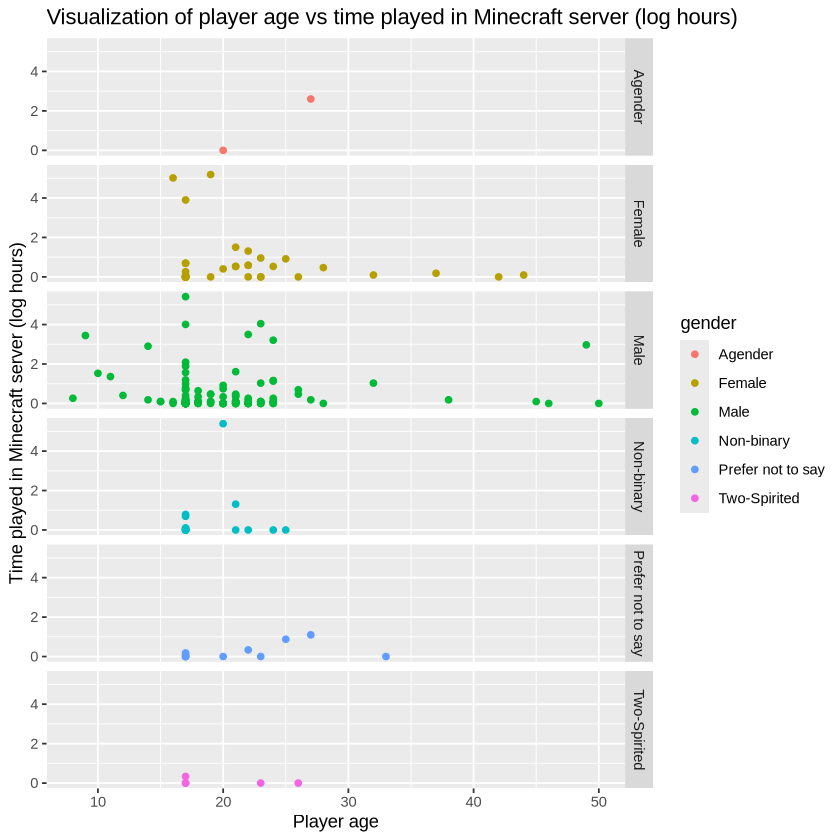

In [65]:
#Converting played_hours to log_played_hours for better data plotting visualization
explore_playerdemog<-playerdemog|>
    mutate(log_hours=log(1+played_hours))


#Scatterplot of log_played_hours and age
options(repr.plot.width=7, repr.plot.length=7) #Adjusting size of plot

explore_table<-explore_playerdemog|>
    ggplot(aes(x=Age, y=log_hours, color=gender))+
    geom_point()+
    facet_grid(vars(rows=gender))+
    labs(x="Player age", y="Time played in Minecraft server (log hours)")+
    ggtitle("Visualization of player age vs time played in Minecraft server (log hours)")
explore_table

In [73]:
#assigning genders to numerical values for easier scaling
playerdemog$gender<-as.integer(factor(playerdemog$gender))
playerdemog


played_hours,Age,gender
<dbl>,<dbl>,<int>
223.1,17,3
218.1,20,4
178.2,19,2
150.0,16,2
56.1,23,3
⋮,⋮,⋮
0,17,2
0,17,3
0,20,3


In [71]:
Male 

[1] 3 4 2 1 5 6

ERROR: Error in eval(expr, envir, enclos): object 'gender' not found


In [68]:
#using KNN regression to determine how much a player of a certain gender and age 
#will be doing a 5 fold cross validation on the data set TO DETERMINE THE BEST K
#data should be split into training and testing

#split data into training and testing data sets, 70:30 in training:testing 
isplit<-initial_split(playerdemog, prop=0.7, strata=played_hours)
player_training<-training(isplit)
player_testing<-testing(isplit)

#forming a recipe 
hour_recipe<-recipe(played_hours ~., data=player_training)  #using all predictors in the dataset
    step_scale(all_numeric())|> 
    step_center(all_numeric()) 

#forming a tuning model to determine best k
tune_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("regression") #doing a regression algorithm to predict played hours

#5-fold cross-validation
#folds are created in a random way, so re-running this code would result in slight differences in prediction estimates
vfold<-vfold_cv(player_training, v=5, strata=played_hours)


#developing a fit
tune_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(tune_spec)


#setting a range of k=1-10 to find the best k
kvals<-tibble(neighbors=seq(from=1, to=10, by=1))

#collecting data to find the smallest RMSE
kvals_result<-tune_fit|>
    tune_grid(resamples=vfold, grid=kvals)|>
    collect_metrics()|>
    filter(.metric=="rmse")
kvals_result

# finding k value with minimum rmse for use in testing model
kvals_min<-kvals_result|>
   slice_min(mean, n=1)|>#finds the row with the minimum mean
    pull(neighbors)
kvals_min


ERROR: Error in `*tmp*`$steps: $ operator is invalid for atomic vectors
